In [1]:
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from VPU import OpenVINOHandler
from craterdetection.deepmoon import template_match_t

exp = OpenVINOHandler('DeepMoon', device='CPU')

sd_input_images = np.load('blobs/sd_input_images.npy').transpose(0, 3, 1, 2)
sd_target_masks = np.load('blobs/sd_target_masks.npy')
exp

OpenVINOHandler(device=CPU, input_layout=NCHW, input_shape=(1, 1, 256, 256))

In [2]:
%%time
batch = sd_input_images[0:10]
targets = sd_target_masks[0:10]
out = exp.infer(batch)

/usr/local/Caskroom/miniconda/base/envs/openvino/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 35.3 s, sys: 257 ms, total: 35.5 s
Wall time: 5.81 s


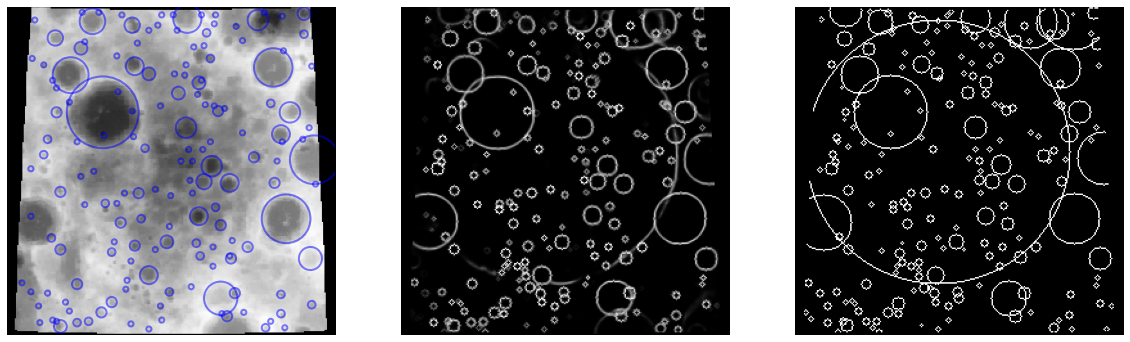

In [3]:
i = 2

extracted_rings = template_match_t(out[i, 0].copy(), minrad=2.5)

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(batch[i, 0], cmap='Greys_r')
axes[0].axis('off')
axes[1].imshow(out[i, 0], cmap='Greys_r')
axes[1].axis('off')
axes[2].imshow(targets[i], cmap='Greys_r')
axes[2].axis('off')

for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    axes[0].add_artist(circle)

(-0.5, 255.5, 255.5, -0.5)

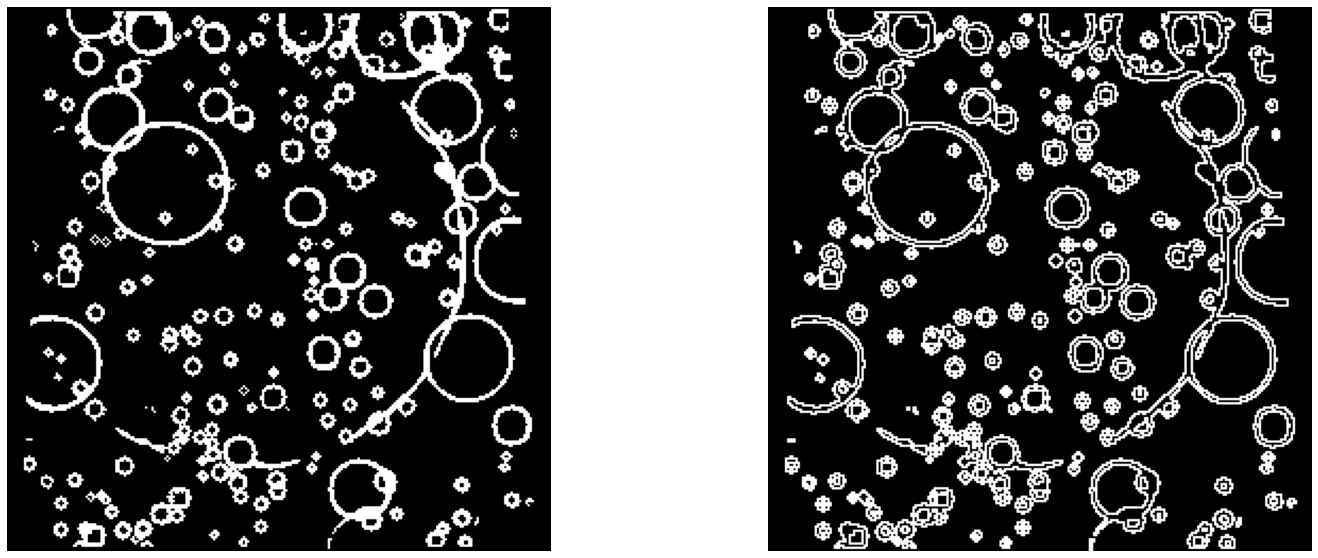

In [4]:
# cv2.MORPH_RECT
# cv2.MORPH_CROSS
# cv2.MORPH_ELLIPSE
i = 2

erosion_size = 0
max_elem = 2
max_kernel_size = 21

def erosion(src, erosion_type, erosion_size):
    element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    erosion_dst = cv2.erode(src, element)
    return erosion_dst
    
def dilatation(src, dilatation_type, dilatation_size):
    element = cv2.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    dilatation_dst = cv2.dilate(src, element)
    return dilatation_dst

src = out[i, 0].copy()

fig, axes = plt.subplots(1,2, figsize=(25, 10))

ret, src = cv2.threshold(src, 0.1, 1, cv2.THRESH_BINARY)

axes[0].imshow(src, cmap='Greys_r')
axes[0].axis('off')

n = 2
kernel = np.ones((n,n),np.uint8)
src = cv2.morphologyEx(src, cv2.MORPH_GRADIENT, kernel)
# src = erosion(src, cv2.MORPH_ELLIPSE, 1)
axes[1].imshow(src, cmap='Greys_r')
axes[1].axis('off')


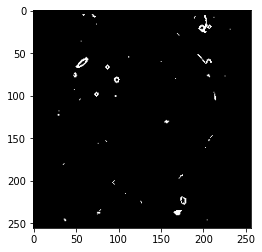

In [5]:
src = out[i, 0].copy()
ret, src = cv2.threshold(src, 0.2, 1, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(np.uint8(src), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.imshow(cv2.drawContours(src, contours, -1, (0,255,0), 3), cmap='Greys_r')

CPU times: user 74.8 ms, sys: 8.79 ms, total: 83.6 ms
Wall time: 75.6 ms


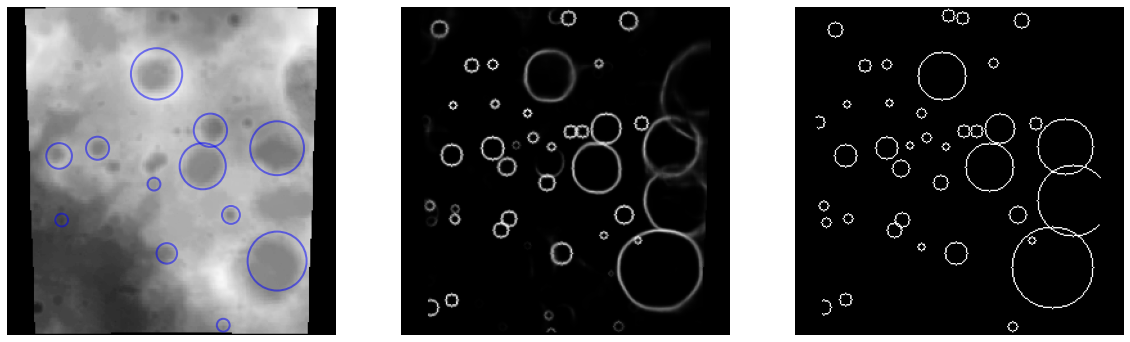

In [170]:
%%time

i = 4


fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(batch[i, 0], cmap='Greys_r')
axes[0].axis('off')
axes[1].imshow(out[i, 0], cmap='Greys_r')
axes[1].axis('off')
axes[2].imshow(targets[i], cmap='Greys_r')
axes[2].axis('off')

src = out[i, 0].copy()
# ret, src = cv2.threshold(src, 0.3, 1, cv2.THRESH_BINARY)
output = src.copy()*255
canvas = np.zeros_like(src)

# Find circles
circles = cv2.HoughCircles(np.uint8(src*255), cv2.HOUGH_GRADIENT, 1, 20, None, 160, 25, 1, 25)

# If some circle is found
if circles is not None:
    # Get the (x, y, r) as integers
    circles = np.round(circles[0, :]).astype("int")
    
    # loop over the circles
    for x, y, r in circles:
        circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
        axes[0].add_artist(circle)
else:
    print("No circles found!")

In [158]:
?cv2.HoughCircles

Docstring:
HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
.   @brief Finds circles in a grayscale image using the Hough transform.
.   
.   The function finds circles in a grayscale image using a modification of the Hough transform.
.   
.   Example: :
.   @include snippets/imgproc_HoughLinesCircles.cpp
.   
.   @note Usually the function detects the centers of circles well. However, it may fail to find correct
.   radii. You can assist to the function by specifying the radius range ( minRadius and maxRadius ) if
.   you know it. Or, in the case of #HOUGH_GRADIENT method you may set maxRadius to a negative number
.   to return centers only without radius search, and find the correct radius using an additional procedure.
.   
.   It also helps to smooth image a bit unless it's already soft. For example,
.   GaussianBlur() with 7x7 kernel and 1.5x1.5 sigma or similar blurring may help.
.   
.   @param image 8-bit, single-chann

/usr/local/Caskroom/miniconda/base/envs/openvino/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
